In [1]:
## load packages
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.stats as ss
import sys
import encoding as enc
import decoding as dec
import util_plot as uplot

seed = 888;
np.random.seed(seed) # fix randomness

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/dz2336/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# do deconvolution in matlab (skip)

In [ ]:
load("../data/sample_calcium_traces.mat");
shape = size(noisy_cal);
K = shape(2);
T = shape(1);
cd = zeros(K,T);
s = zeros(K,T);
sn = zeros(K,1);

for n = 1:K
    [cd(n,:), s(n,:), options] = deconvolveCa(noisy_cal(:,n), 'foopsi', 'ar1', 'smin', 0, 'optimize_pars', false, 'pars', 0.9438634086810337, 'optimize_b', false, 'b', 0);
    sn(n,1) = options.sn;
end

save("../data/sample_deconv_traces.mat", 's', 'sn');
clear all;

# load deconvolved data

In [2]:
## load deconvolved data
deconv = sio.loadmat("../data/sample_deconv_traces.mat");
hd = sio.loadmat("../data/sample_stimulus.mat")['hd'][0];
Y_real = (deconv["s"]/deconv["sn"]).T; # normalize it by noise level (important!)

# play around data: fit MLE on a single neuron (optional)

stimulus in [ -140 , -100 ]
p fit  0.43
k fit  0.79
loc fit  0.0
a fit  2.55


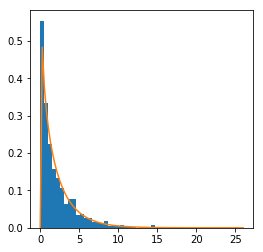

In [3]:
nid = 0; # pick the nid-th neuron
hd_bins = [-140,-100]; # specify the stimulus range, stimulus are all between [-180, 180]
data_pos = ((hd>=hd_bins[0])*(hd<=hd_bins[1]));
data_use = Y_real[:,nid][data_pos];
print('stimulus in [', hd_bins[0], ',', hd_bins[1], ']');
p_fit, k_fit, loc_fit, theta_fit, fig = enc.fitmle(data_use);

# set up params

In [4]:
## result saving path
path = './results/';

## encoding params
n_epochs = 1500; # number of epochs 
learning_rate = 1e-2; # step size 
gen_nodes = 30; # number of nodes used in hidden layers

thresh = 0; # threshold for bernoulli model
# if you use hard-threshold method, use the smin you chose for deconvolution; 
# if you use soft-threshold (L1) method, you should set this to 0;
# if you further process the deconvolved traces (eg. downsample), make sure you set thresh to be
#the minimum non-zero number minus some small number (eg. 1e-6).
gam_shift = 1e-4; # shift for gamma model, in general take it as a small number
factor = np.ones(Y_real.shape[1])*thresh; # location parameter for zig model

## decoding params
bin_len = 181; # number of bins used for bayesian decoding analysis

# split data into training, validation, test

In [5]:
## split data
nTrain = 11153;
nValid = 3584;
nTest = Y_real.shape[0]-nTrain-nValid;

Y_train = Y_real[:nTrain,:];
Y_valid = Y_real[nTrain:(nTrain+nValid),:];
Y_test = Y_real[(nTrain+nValid):,:];

hd_train = hd[:nTrain];
hd_valid = hd[nTrain:(nTrain+nValid)];
hd_test = hd[(nTrain+nValid):];

Y_const = Y_real;
hd_const = hd;

hd_bins_use = np.linspace(-180,180,bin_len)[1:];
hd_temp = uplot.getBins(hd, hd_bins_use);

# train encoding models

In [6]:
## (fitting takes about 10 mins)
## output variables
# spl_values_xx is the fitted tuning curve as function of stimulus, yfit_xx is fitted mean response at each time point for xx model
# spl_yy_values_xx is the fitted yy params as function of stimulus, xx_yy is fitted yy params at each time point for xx model

## poisson
spl_values_poi,yfit_poi,cost_poi,test_cost_poi=enc.poissonRunner(Y_train,Y_valid,hd_train,hd_valid,hd_test,n_epochs=n_epochs,learning_rate=learning_rate,gen_nodes=gen_nodes,bin_len=bin_len,path=path);

## bernoulli
spl_values_ber, yfit_ber, cost_ber, test_cost_ber = enc.bernoulliRunner(Y_train,Y_valid,hd_train,hd_valid,hd_test, thresh=thresh,n_epochs=n_epochs,learning_rate=learning_rate,gen_nodes=gen_nodes,bin_len=bin_len,path=path);

## gamma
spl_values_gam,spl_k_values_gam,spl_theta_values_gam,yfit_gam,gam_k,gam_theta,cost_gam,test_cost_gam=enc.gammaRunner(Y_train,Y_valid,hd_train,hd_valid,hd_test,factor=gam_shift,n_epochs=n_epochs,learning_rate=learning_rate,gen_nodes=gen_nodes,bin_len=bin_len,path=path);

## zig
spl_values_zig, spl_p_values_zig, spl_theta_values_zig, zig_k, zig_loc, yfit_zig, zig_p, zig_theta, cost_zig, test_cost_zig = enc.sngRlxRunner(Y_train, Y_valid, hd_train,hd_valid, hd_test, factor, n_epochs=n_epochs,learning_rate=5e-3, gen_nodes=gen_nodes,bin_len=bin_len,path=path);

INFO:tensorflow:Restoring parameters from ./results/poi.ckpt
INFO:tensorflow:Restoring parameters from ./results/ber.ckpt
INFO:tensorflow:Restoring parameters from ./results/gamma.ckpt


/home/dz2336/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from ./results/sng_rlx.ckpt


# bayesian decoding analysis

In [7]:
## output variables
# xx_mean_decode is posterior mean, xx_decode is posterior mode, xx_lik_mat is posterior likelihood for xx model

## poisson
poi_mean_decode, poi_decode, poi_lik_mat = dec.poissonDecoding(Y_const, spl_values_poi, bin_len=bin_len);

## bernoulli
ber_mean_decode, ber_decode, ber_lik_mat = dec.bernoulliDecoding(Y_const, thresh, spl_values_ber, bin_len=bin_len);

## gamma
gam_mean_decode,gam_decode,gam_lik_mat=dec.gammaDecoding(Y_const,spl_k_values_gam,spl_theta_values_gam,factor=gam_shift,bin_len=bin_len);

## zig
zig_mean_decode, zig_decode, zig_lik_mat = dec.sngRlxDecoding(Y_const, spl_theta_values_zig, 
                                                           spl_p_values_zig, zig_k, zig_loc, bin_len=bin_len);

# check encoding results

In [11]:
## sample data
y_poisson, p_poi = enc.samplePoisson(yfit_poi, seed=seed);
y_bernoulli = enc.sampleBernoulli(yfit_ber, seed=seed);
y_zig = enc.sampleSngRlx(zig_p, zig_k, zig_theta, zig_loc, seed=seed);
y_gamma = enc.sampleGamma(gam_k, gam_theta, seed=seed);

## diagnostic plots

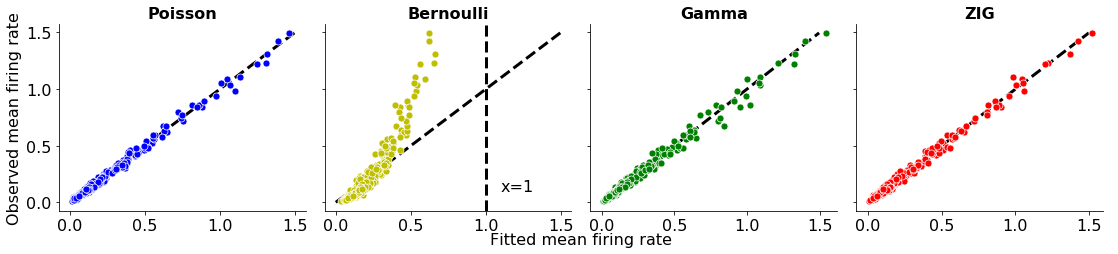

In [12]:
## plot fitted vs observed mean
fig_rate = uplot.plotSampleRatem(Y_const, hd_const, y_poisson,
                                 y_bernoulli, y_gamma, y_zig,ss=0,bins=10);

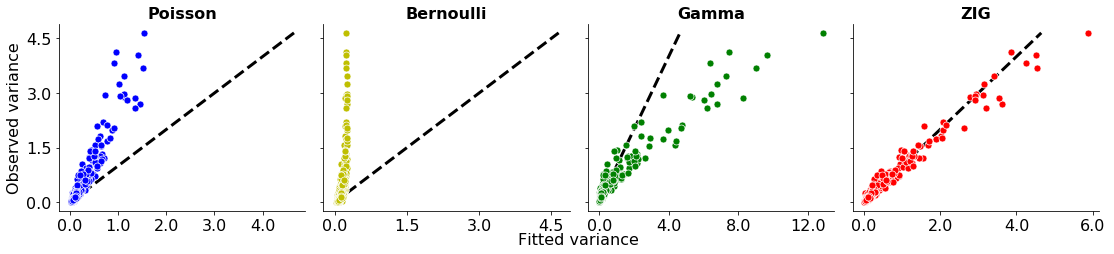

In [13]:
## plot fitted vs observed variance
fig_var = uplot.plotSampleVarm(Y_const,y_poisson, y_bernoulli, y_gamma,
                               y_zig,hd_const,ss=0,bins=10);

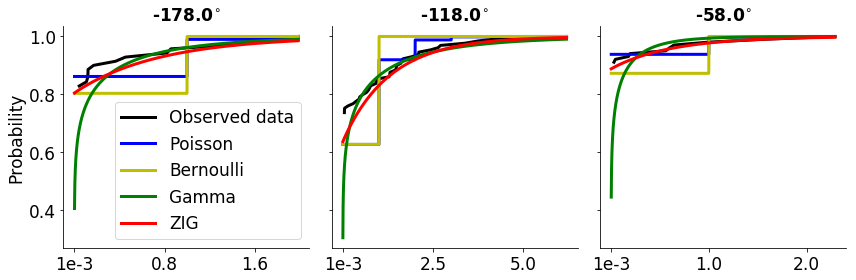

In [14]:
## plot fitted vs empirical cdf
nid = 1;
fig_cdfslab = uplot.plotCdfSlabm(Y_real, hd_temp, spl_values_poi,spl_values_ber,
                   spl_theta_values_zig, zig_k, zig_loc,spl_p_values_zig,
                   spl_theta_values_gam, spl_k_values_gam,hd_bins_use,
           bin_list=[0,30,60], size=[1,3], nid=nid); #[0,30,60,90,120,150]

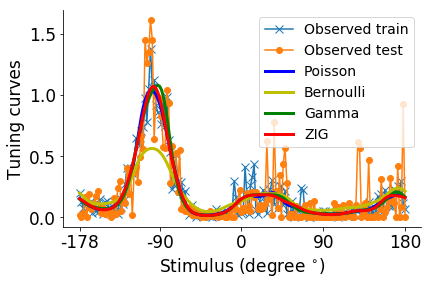

In [15]:
## plot fitted tunning curve
num=1; 
nid = 1;
tuning_curve = enc.get_tc(Y_train, hd_train, bin_len);
tuning_curve2 = enc.get_tc(Y_test, hd_test);
fig_tc = uplot.plotTC(num, spl_values_poi[:,nid:], 
                      spl_values_ber[:,nid:], spl_values_gam[:,nid:], spl_values_zig[:,nid:],
             tuning_curve[:,nid:],tuning_curve2[:,nid:]);

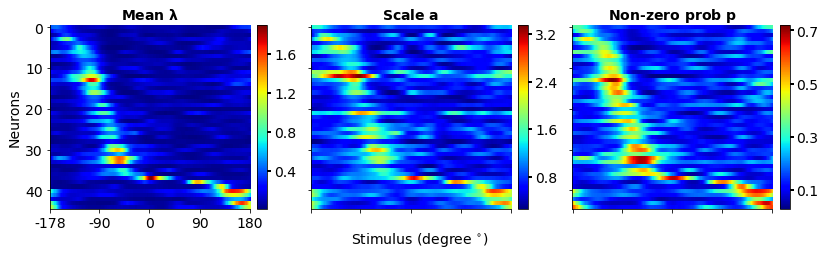

In [16]:
## plot fitted params
fig_params=uplot.plotParams([spl_values_poi, spl_theta_values_zig, spl_p_values_zig],
                 ['Mean $\mathbf{\lambda}$','Scale $\mathbf{a}$', 'Non-zero prob $\mathbf{p}$'], bin_len);

# check decoding results

In [17]:
## compute decoding mean absolute error

_,poi_error = dec.error(poi_mean_decode[:], hd_const[:]);
_,ber_error = dec.error(ber_mean_decode[:], hd_const[:]);
_,zig_error = dec.error(zig_mean_decode[:], hd_const[:]);
_,gam_error = dec.error(gam_mean_decode[:], hd_const[:]);

# training error
print('training error: poisson:', np.round(np.abs(poi_error[:nTrain]).sum()/nTrain,2),
      'bernoulli:', np.round(np.abs(ber_error[:nTrain]).sum()/nTrain,2),
      'gamma:', np.round(np.abs(gam_error[:nTrain]).sum()/nTrain,2),
      'zig:', np.round(np.abs(zig_error[:nTrain]).sum()/nTrain,2))

# test error
print('test error: poisson:', np.round(np.abs(poi_error[(nTrain+nValid):]).sum()/nTest,2),
      'bernoulli:', np.round(np.abs(ber_error[(nTrain+nValid):]).sum()/nTest,2),
      'gamma:', np.round(np.abs(gam_error[(nTrain+nValid):]).sum()/nTest,2),
      'zig:', np.round(np.abs(zig_error[(nTrain+nValid):]).sum()/nTest,2))


training error: poisson: 33.04 bernoulli: 34.34 gamma: 31.35 zig: 28.89
test error: poisson: 31.76 bernoulli: 33.72 gamma: 29.95 zig: 28.35


## diagnostic plots

In [ ]:
## compute CI coverage rate when varying multiple confidence levels (this can be slow)
width_med_ci, width_mean_ci, conf_rate_ci = dec.getVaryCI(Y_const, hd_const, hd_bins_use, 
                                                          zig_lik_mat, poi_lik_mat,
                                                          ber_lik_mat, gam_lik_mat,
                                                          poi_mean_decode,ber_mean_decode, 
                                                          zig_mean_decode, gam_mean_decode,
                                                          nTrain, nValid,nTest);
# results are in order zig, poisson, bernoulli, gamma
# if only want to compute CI for zig model, please refer to the getVaryCI function in decoding.py

In [ ]:
## plot CI converage rate vs confidence levels and CI converage rate vs CI width
conf_level_list=np.array(list(np.linspace(0.9,0.999,10))[:-1] + [1-1e-2, 1-5e-3, 1-1e-3]);
print(conf_level_list);

fig_cimr = uplot.plotCIcov_mean(conf_rate_ci, width_mean_ci,drop=False);
fig_cilr = uplot.plotCIcov_lev(-np.log10(1-conf_rate_ci), -np.log10(1-conf_level_list),real=False,drop=False);

# save results

In [20]:
## save results
encoding_results = {'poi':[spl_values_poi,yfit_poi,cost_poi,test_cost_poi],'ber':[spl_values_ber, yfit_ber, cost_ber, test_cost_ber],
                    'zig':[spl_values_zig, spl_p_values_zig, spl_theta_values_zig, zig_k, zig_loc, yfit_zig, zig_p, zig_theta, cost_zig, test_cost_zig],
                    'gam':[spl_values_gam,spl_k_values_gam,spl_theta_values_gam,yfit_gam,gam_k,gam_theta,cost_gam,test_cost_gam]};

decoding_results = {'poi':[poi_mean_decode,poi_decode,poi_lik_mat],'ber':[ber_mean_decode,ber_decode,ber_lik_mat],
                    'zig':[zig_mean_decode,zig_decode,zig_lik_mat],'gam':[gam_mean_decode,gam_decode,gam_lik_mat],
                    'stats':[width_med_ci,width_mean_ci,conf_rate_ci]};

np.savez(path+'rlts.npz',encoding_results,decoding_results);